In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

INFO:stancache.seed:Setting seed to 1245502385


## Simulate survival data 

In order to demonstrate the use of this model, we will first simulate some survival data using `survivalstan.sim.sim_data_exp_correlated`. As the name implies, this function simulates data assuming a constant hazard throughout the follow-up time period, which is consistent with the Exponential survival function.

This function includes two simulated covariates by default (`age` and `sex`). We also simulate a situation where hazard is a function of the simulated value for `sex`. 

We also center the `age` variable since this will make it easier to interpret estimates of the baseline hazard.


In [2]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl


INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


*Aside: In order to make this a more reproducible example, this code is using a file-caching function `stancache.cached` to wrap a function call to `survivalstan.sim.sim_data_exp_correlated`. *

## Explore simulated data

Here is what these data look like - this is `per-subject` or `time-to-event` form:

In [3]:
d.head()

,sex,age,rate,true_t,t,event,index,age_centered
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12
1,male,39,0.082085,4.890597,4.890597,True,1,-16.12
2,female,45,0.049787,4.093404,4.093404,True,2,-10.12
3,female,43,0.049787,7.036226,7.036226,True,3,-12.12
4,female,57,0.049787,5.712299,5.712299,True,4,1.88


*It's not that obvious from the field names, but in this example "subjects" are indexed by the field `index`.*

We can plot these data using `lifelines`, or the rudimentary plotting functions provided by `survivalstan`.

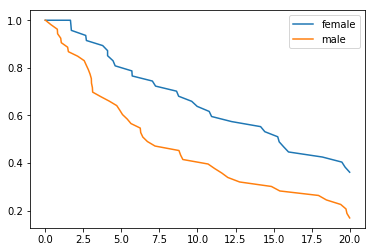

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

## model1: original spec

In [5]:
model_code = '''
functions {
  // Defines the log survival
  vector log_S (vector t, real shape, vector rate) {
    vector[num_elements(t)] log_S;
    for (i in 1:num_elements(t)) {
      log_S[i] = gamma_lccdf(t[i]|shape,rate[i]); 
    }
    return log_S;
  }
  
  // Defines the log hazard
  vector log_h (vector t, real shape, vector rate) {
    vector[num_elements(t)] log_h;
    vector[num_elements(t)] ls;
    ls = log_S(t,shape,rate);
    for (i in 1:num_elements(t)) {
      log_h[i] = gamma_lpdf(t[i]|shape,rate[i]) - ls[i];
    }
    return log_h;
  }
  
  // Defines the sampling distribution
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    log_lik = d .* log_h(t,shape,rate) + log_S(t,shape,rate);
    prob = sum(log_lik);
    return prob;
  }
}

data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event;     // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                    // matrix of covariates (with n rows and H columns)
}

parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}

transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  for (i in 1:N) {
    mu[i] = exp(linpred[i]);
  }
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

Now, we are ready to fit our model using `survivalstan.fit_stan_survival_model`. 

We pass a few parameters to the fit function, many of which are required. See ?survivalstan.fit_stan_survival_model for details. 

Similar to what we did above, we are asking `survivalstan` to cache this model fit object. See [stancache](http://github.com/jburos/stancache) for more details on how this works. Also, if you didn't want to use the cache, you could omit the parameter `FIT_FUN` and `survivalstan` would use the standard pystan functionality.


In [6]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 1',
    model_code = model_code,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_14429915565770599621.pystan_2_18_1_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_14429915565770599621.pystan_2_18_1_0.stanfit.chains_4.data_36753546383.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Loading result from cache


In [7]:
# 0:01:33.270480 elapsed

In [8]:
survivalstan.utils.print_stan_summary([testfit], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -272.845825  0.022499  1.435829 -276.502302 -272.511241 -271.047870  1.000226
alpha      1.023739  0.002147  0.152227    0.755217    1.014877    1.349258  1.001638
beta[1]   -3.029740  0.004090  0.274891   -3.614153   -3.011143   -2.532143  1.001077
beta[2]    0.618876  0.003042  0.239763    0.156590    0.614498    1.108694  1.000019
beta[3]   -0.003055  0.000162  0.013851   -0.030628   -0.002910    0.023814  1.000772


## model2: alternate version of surv_gamma_lpdf

In [9]:
model_code2 = '''
functions {
  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    for (i in 1:num_elements(t)) {
      log_lik[i] = d[i] * (gamma_lpdf(t[i]|shape,rate[i]) - gamma_lccdf(t[i]|shape,rate[i]))
                      + gamma_lccdf(t[i]|shape,rate[i]);
    }
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event;     // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                    // matrix of covariates (with n rows and H columns)
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector<lower=0>[N] mu;
  {
      vector[N] linpred;
      linpred = x*beta;
      mu = exp(linpred);
  }
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

In [10]:
testfit2 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 2',
    model_code = model_code2,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_9177012762674257483.pystan_2_18_1_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_9177012762674257483.pystan_2_18_1_0.stanfit.chains_4.data_36753546383.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Loading result from cache


In [11]:
# 0:01:20.742172 elapsed

In [12]:
survivalstan.utils.print_stan_summary([testfit2], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -272.859001  0.023962  1.470993 -276.580657 -272.522315 -271.028212  1.000202
alpha      1.022005  0.002037  0.150233    0.749135    1.014273    1.341307  1.000132
beta[1]   -3.032481  0.003923  0.273614   -3.612430   -3.020702   -2.543998  1.000088
beta[2]    0.614401  0.003031  0.241061    0.152624    0.610390    1.103668  0.999922
beta[3]   -0.003198  0.000161  0.013956   -0.031153   -0.003048    0.023837  0.999972


## model3: use `log_mix` inside surv_gamma_lpdf

In [13]:
model_code3 = '''
functions {
  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    for (i in 1:num_elements(t)) {
      log_lik[i] = log_mix(d[i], gamma_lpdf(t[i]|shape,rate[i]), gamma_lccdf(t[i]|shape,rate[i]));
    }
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event; // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                   // matrix of covariates (with n rows and H columns)
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  mu = exp(linpred);
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

In [14]:
testfit3 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 3',
    model_code = model_code3,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_1293841621968646714.pystan_2_18_1_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_1293841621968646714.pystan_2_18_1_0.stanfit.chains_4.data_36753546383.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Loading result from cache


In [15]:
# 0:00:42.036498 elapsed

In [16]:
survivalstan.utils.print_stan_summary([testfit3], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -272.836212  0.023769  1.461660 -276.474541 -272.493666 -271.040873  1.001796
alpha      1.023676  0.001992  0.149010    0.746153    1.017081    1.331976  0.999766
beta[1]   -3.030396  0.004034  0.267378   -3.606247   -3.013798   -2.553470  1.000366
beta[2]    0.619250  0.003194  0.242402    0.156037    0.617779    1.106182  1.000445
beta[3]   -0.003286  0.000155  0.013740   -0.030794   -0.003000    0.023025  1.000123


## model4: vectorize surv_gamma_lpdf

In [17]:
model_code4 = '''
functions {
    int count_value(vector a, real val) {
        int s;
        s = 0;
        for (i in 1:num_elements(a)) 
            if (a[i] == val) 
                s = s + 1;
        return s;
    }

  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate, int num_cens, int num_obs) {
    vector[2] log_lik;
    int idx_obs[num_obs];
    int idx_cens[num_cens];
    real prob;
    int i_cens;
    int i_obs;
    i_cens = 1;
    i_obs = 1;
    for (i in 1:num_elements(t)) {
        if (d[i] == 1) {
            idx_obs[i_obs] = i;
            i_obs = i_obs+1;
        }
        else {
            idx_cens[i_cens] = i;
            i_cens = i_cens+1;
        }
    }
    print(idx_obs);
    log_lik[1] = gamma_lpdf(t[idx_obs] | shape, rate[idx_obs]);
    log_lik[2] = gamma_lccdf(t[idx_cens] | shape, rate[idx_cens]);
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event; // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                   // matrix of covariates (with n rows and H columns)
}
transformed data {
  int num_cens;
  int num_obs;
  num_obs = count_value(event, 1);
  num_cens = N - num_obs;
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  mu = exp(linpred);
}
model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu, num_cens, num_obs);
}
'''

In [18]:
testfit4 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 4',
    model_code = model_code4,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_16881928540873162731.pystan_2_18_1_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_16881928540873162731.pystan_2_18_1_0.stanfit.chains_4.data_36753546383.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Loading result from cache


In [19]:
# 0:00:16.703755 elapsed

In [20]:
survivalstan.utils.print_stan_summary([testfit4], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -272.823550  0.022981  1.461548 -276.488239 -272.492426 -271.021688  1.000197
alpha      1.023161  0.002054  0.150942    0.749636    1.011858    1.346196  1.000033
beta[1]   -3.030795  0.003943  0.275100   -3.610841   -3.013843   -2.531514  0.999949
beta[2]    0.615333  0.002998  0.240180    0.152485    0.613556    1.096432  0.999838
beta[3]   -0.003085  0.000159  0.013548   -0.030261   -0.002951    0.023048  1.000245


## compare coefficient estimates for each model spec

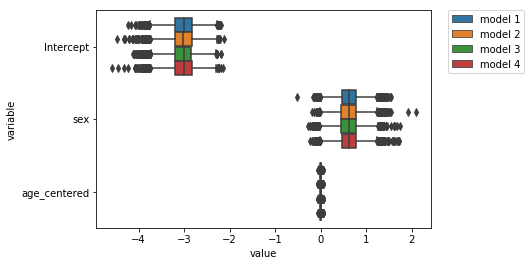

In [21]:
survivalstan.utils.plot_coefs([testfit, testfit2, testfit3, testfit4])